In [215]:
# Installing Kaggle Environment
!pip install kaggle-environments --quiet

In [216]:
# Importing necessary libraries
from kaggle_environments import make, evaluate
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Environemnt Setup

In [217]:
# Create the game environment
# Set debug=True to see the errors if your agent refuses to run
env = make("connectx", debug=True)

In [218]:
# Creating customized environment
rows = 4
columns = 5
in_a_row = 3
debug_mode = True
env = make("connectx", {"rows": rows, "columns": columns, "inarow": in_a_row}, steps=[], debug=debug_mode)

# Understanding Game Play, Environment.

In [219]:
# How our agent works with the environment
nr = 4
nc = 5
board = [0]*(nr*nc)

def get_available_actions(board, nc, nr):
    available_actions = []
    for col in range(nc):
        if board[col * nr] == 0:
            available_actions.append(col)
    return available_actions, board
col_index, board = get_available_actions(board, nc, nr)
print('available columns to fill:', col_index, '\nboard or status:', board)

available columns to fill: [0, 1, 2, 3, 4] 
board or status: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [220]:
# Agent creation
def agent0(observation, configuration):
  print('board',observation.board)
  print('mark',observation.mark)

In [221]:
# Playing with default random agent
env.run([agent0, 'negamax'])
env.render(mode="ipython")

board [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
mark 1
board [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0]
mark 1
board [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 2, 0, 0, 0]
mark 1
board [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 2, 2, 0, 0]
mark 1
Invalid Action: Invalid column: 0


In [222]:
# Load a default agents
df_random = "random"
df_negamax = 'negamax'

In [223]:
env.specification.observation

{'remainingOverageTime': {'description': 'Total remaining banked time (seconds) that can be used in excess of per-step actTimeouts -- agent is disqualified with TIMEOUT status when this drops below 0.',
  'shared': False,
  'type': 'number',
  'minimum': 0,
  'default': 60},
 'step': {'description': 'Current step within the episode.',
  'type': 'integer',
  'shared': True,
  'minimum': 0,
  'default': 0},
 'board': {'description': 'Serialized grid (rows x columns). 0 = Empty, 1 = P1, 2 = P2',
  'type': 'array',
  'shared': True,
  'default': []},
 'mark': {'defaults': [1, 2],
  'description': 'Which checkers are the agents.',
  'enum': [1, 2]}}

In [224]:
# Selects random valid column
def agent_random(obs):
    valid_moves = [col for col in range(columns) if obs.board[col] == 0]
    return int(np.random.choice(valid_moves))

# Selects middle column
def agent_middle(obs):
    valid_moves = [col for col in range(columns) if obs.board[col] == 0]
    return valid_moves[len(valid_moves)//2]

# Selects leftmost valid column
def agent_leftmost(obs):
    valid_moves = [col for col in range(len(obs.board)) if obs.board[col] == 0]
    return valid_moves[0]

def agent_rightmost(obs):
  valid_moves = [col for col in range(columns) if obs.board[col] == 0]
  return valid_moves[-1]

In [225]:
trainer = env.train([None, df_negamax])
obs = trainer.reset()
agent0 = agent_random(obs)
env.run([agent0, df_negamax])
env.render(mode="ipython")

Invalid Action: Invalid column: 0


# My Agents

In [226]:
# My Random Agent with no more illegal moves and no more bias towards specific column
class RandomAgent2():
    def __init__(self, seed = None):
        self.epsilon = 0.1  # Exploration rate
        self.policy = defaultdict(lambda: None)  # No default action to avoid the bias towards specific column
        self.seed = seed
        if self.seed is not None:
            np.random.seed(self.seed)
    def act(self, obs):
        valid_moves = [col for col in range(columns) if obs.board[col] == 0]
        if np.random.rand() < self.epsilon:
            # Explore: choose a random valid action
            action = np.random.choice(valid_moves)
            return int(action)
        else:
            # Exploit: use the current policy or a random valid move if policy is not available
            current_state = tuple(obs.board)
            if self.policy[current_state] is not None and self.policy[current_state] in valid_moves:
                action = self.policy[current_state]
                return int(action)
            else:
                action = np.random.choice(valid_moves)
                return int(action)
    def learn(self, obs, action, reward):
        self.epsilon *= 0.9995  # Decaying epsilon
        current_state = tuple(obs.board)
        if reward is not None and reward >= 0:
            # Update the policy with the new action if the reward is positive or zero
            self.policy[current_state] = action

In [227]:
agent2 = RandomAgent2(seed = 1)

In [228]:
trainer = env.train([None, df_random])
obs = trainer.reset()
rewards = []
t_reward = 0
total_episode = 100
for _ in range(total_episode):
    action = agent2.act(obs)
    obs, reward, done, info = trainer.step(action)
    agent2.learn(obs, action, reward)
    t_reward += reward
    rewards.append(t_reward)
    if reward == 1:
        env.render(mode='ipython')
        obs = trainer.reset()
        print(reward)
        print(agent2.policy)
        print('Total reward:', t_reward)
    if done:
        obs = trainer.reset()


1
defaultdict(<function RandomAgent2.__init__.<locals>.<lambda> at 0x7f630c75d090>, {(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0): None, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 2, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 2, 1): 4})
Total reward: 1


1
defaultdict(<function RandomAgent2.__init__.<locals>.<lambda> at 0x7f630c75d090>, {(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0): None, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 2, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 2, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0): 0, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2): 1, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 2): 1, (0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 2): 1})
Total reward: 1


1
defaultdict(<function RandomAgent2.__init__.<locals>.<lambda> at 0x7f630c75d090>, {(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0): None, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 2, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 2, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0): 0, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2): 1, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 2): 1, (0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 2): 1, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0): 3, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 2): 3, (0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 2): 3})
Total reward: 2


1
defaultdict(<function RandomAgent2.__init__.<locals>.<lambda> at 0x7f630c75d090>, {(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0): None, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 2, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 2, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0): 0, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2): 1, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 2): 1, (0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 2): 1, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0): 3, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 2): 3, (0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 2): 3, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 2, 0, 0, 1): 4, (0

1
defaultdict(<function RandomAgent2.__init__.<locals>.<lambda> at 0x7f630c75d090>, {(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0): None, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 2, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 2, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0): 0, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2): 1, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 2): 1, (0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 2): 1, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0): 3, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 2): 3, (0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 2): 3, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 2, 0, 0, 1): 4, (0

1
defaultdict(<function RandomAgent2.__init__.<locals>.<lambda> at 0x7f630c75d090>, {(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0): None, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 2, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 2, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0): 0, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2): 1, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 2): 1, (0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 2): 1, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0): 3, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 2): 3, (0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 2): 3, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 2, 0, 0, 1): 4, (0

1
defaultdict(<function RandomAgent2.__init__.<locals>.<lambda> at 0x7f630c75d090>, {(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0): None, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 2, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 2, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0): 0, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2): 1, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 2): 1, (0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 2): 1, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0): 3, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 2): 3, (0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 2): 3, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 2, 0, 0, 1): 4, (0

1
defaultdict(<function RandomAgent2.__init__.<locals>.<lambda> at 0x7f630c75d090>, {(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0): None, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 2, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 2, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0): 0, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2): 1, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 2): 1, (0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 2): 1, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0): 3, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 2): 3, (0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 2): 3, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 2, 0, 0, 1): 4, (0

1
defaultdict(<function RandomAgent2.__init__.<locals>.<lambda> at 0x7f630c75d090>, {(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0): None, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 2, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 2, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0): 0, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2): 1, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 2): 1, (0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 2): 1, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0): 3, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 2): 3, (0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 2): 3, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 2, 0, 0, 1): 4, (0

1
defaultdict(<function RandomAgent2.__init__.<locals>.<lambda> at 0x7f630c75d090>, {(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0): None, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 2, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 2, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0): 0, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2): 1, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 2): 1, (0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 2): 1, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0): 3, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 2): 3, (0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 2): 3, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 2, 0, 0, 1): 4, (0

1
defaultdict(<function RandomAgent2.__init__.<locals>.<lambda> at 0x7f630c75d090>, {(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0): None, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 2, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 2, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0): 0, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2): 1, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 2): 1, (0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 2): 1, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0): 3, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 2): 3, (0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 2): 3, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 2, 0, 0, 1): 4, (0

1
defaultdict(<function RandomAgent2.__init__.<locals>.<lambda> at 0x7f630c75d090>, {(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0): None, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 2, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 2, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0): 0, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2): 1, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 2): 1, (0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 2): 1, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0): 3, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 2): 3, (0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 2): 3, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 2, 0, 0, 1): 4, (0

1
defaultdict(<function RandomAgent2.__init__.<locals>.<lambda> at 0x7f630c75d090>, {(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0): None, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 2, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 2, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0): 0, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2): 1, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 2): 1, (0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 2): 1, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0): 3, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 2): 3, (0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 2): 3, (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1): 4, (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 2, 0, 0, 1): 4, (0

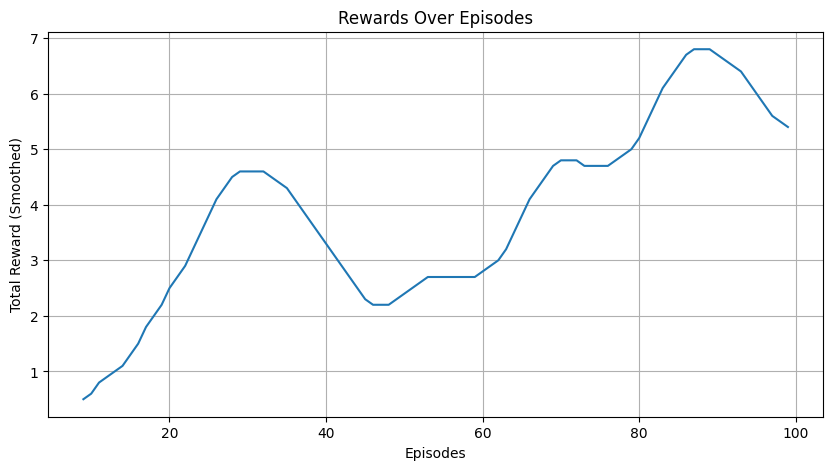

In [229]:
# Convert the list to a DataFrame to use the rolling mean function
rewards_df = pd.DataFrame(rewards, columns=['Reward'])

# Compute the rolling mean with a window, e.g., 50 episodes
rewards = rewards_df['Reward'].rolling(window=10).mean()

plt.figure(figsize=(10, 5))
plt.plot(rewards)
plt.title('Rewards Over Episodes')
plt.xlabel('Episodes')
plt.ylabel('Total Reward (Smoothed)')
plt.grid(True)
plt.show()


In [230]:
class SARSAAgent():
    def __init__(self, alpha=0.5, gamma=0.9, epsilon=0.1, learn_episodes=5, seed = None):
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.policy = defaultdict(lambda: np.zeros(columns), dtype = int)
        self.learn_episodes = learn_episodes
        self.current_episode = 0
        self.seed = seed
        if self.seed is not None:
            np.random.seed(self.seed)
    def act(self, obs):
        state = tuple(obs['board'])
        # Choose action based on epsilon-greedy policy
        if np.random.rand() > self.epsilon:
            return int(np.random.choice([c for c in range(columns) if obs['board'][c] == 0]))
        else:
            return int(np.argmax(self.policy[state]))

    def learn(self, obs, action, reward, next_obs, next_action):
        state = tuple(obs['board'])
        next_state = tuple(next_obs['board'])
        current_q = self.policy[state][action]
        future_q = self.policy[next_state][next_action]
        self.policy[state][action] += self.alpha * (reward + self.gamma * future_q - current_q)

    def end_episode(self):
        self.current_episode += 1

In [231]:
# Instantiate the agent
agent3 = SARSAAgent(seed = 2)

def agent_play(obs):
    action = agent3.act(obs)
    return action

# Play multiple games
num_episodes = 50
results = []
rewards = []
t_reward = 0
for i in range(num_episodes):
    trainer = env.train([None, df_random])
    obs = trainer.reset()
    done = False
    while not done:
        action = agent_play(obs)
        next_obs, reward, done, info = trainer.step(action)
        if not done:  # Check if the game is not over
            next_action = agent3.act(next_obs)
            agent3.learn(obs, action, reward, next_obs, next_action)
        obs = next_obs
    agent3.end_episode()
    if reward is not None:
        t_reward += reward
        rewards.append(t_reward)
    results.append(reward)
    print(f"Game {i+1}, Reward: {reward}")
    if reward == 1:
      env.render(mode = 'ipython')

# Output the results of all games
print('Total reward:', t_reward)
print("Results from all games:", results)

Output hidden; open in https://colab.research.google.com to view.

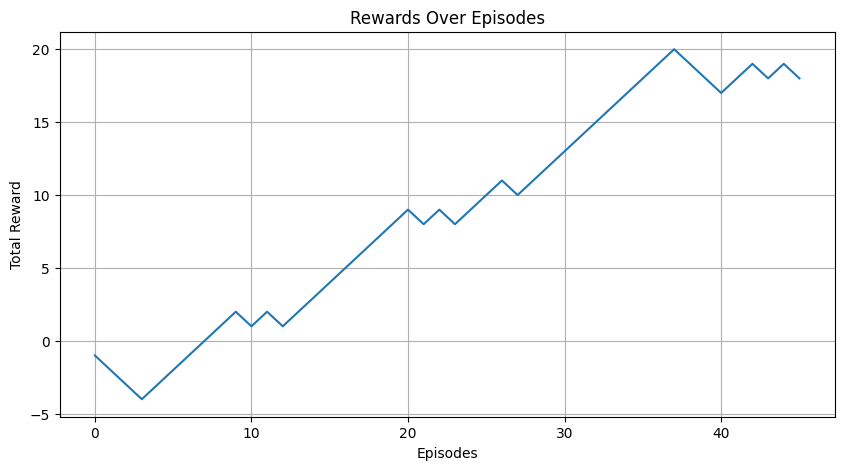

In [232]:
plt.figure(figsize=(10, 5))
plt.plot(rewards)
plt.title('Rewards Over Episodes')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

In [233]:
# play using trained polcicy

def trained_policy(agent, obs, columns):
    for j, _ in agent.policy.items():
        if j == tuple(obs.board):
            value = int(tuple(agent.policy.values())[1])
            return value
        else:
            return np.random.choice(columns)

In [234]:
env.run([trained_policy(agent3, obs, columns), df_negamax])
env.render(mode = 'ipython')

Invalid Action: Invalid column: 2


In [235]:
# Agent policy for each observation and number of times specific action made
for _ in range(len(agent3.policy)):
    print(agent3.policy.items())

Output hidden; open in https://colab.research.google.com to view.

In [236]:
class QLearningAgent():
    def __init__(self, alpha=0.5, gamma=0.9, epsilon=0.1, learn_episodes=5, seed = None):
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.policy = defaultdict(lambda: np.zeros(columns), dtype = int)
        self.learn_episodes = learn_episodes
        self.current_episode = 0
        self.seed = seed
        if self.seed is not None:
            np.random.seed(self.seed)
    def act(self, obs):
        state = tuple(obs['board'])
        # Choose action based on epsilon-greedy policy
        if np.random.rand() > self.epsilon:
            # Exploration: Randomly select from available actions
            return int(np.random.choice([c for c in range(columns) if obs['board'][c] == 0]))
        else:
            # Exploitation: Select the action with the maximum value from the policy
            return int(np.argmax(self.policy[state]))

    def learn(self, obs, action, reward, next_obs):
        state = tuple(obs['board'])
        next_state = tuple(next_obs['board'])
        # Q-Learning update rule
        current_q = self.policy[state][action]
        # Use max to find the best future reward that could be obtained from the next state
        future_q = np.max(self.policy[next_state])
        self.policy[state][action] += self.alpha * (reward + self.gamma * future_q - current_q)

    def end_episode(self):
        self.current_episode += 1

In [237]:
# Instantiate the agent
agent4 = QLearningAgent(seed = 3)

def agent_play(obs):
    action = agent4.act(obs)
    return action

# Play multiple games
num_episodes = 50
results = []
rewards = []
t_reward = 0
for i in range(num_episodes):
    trainer = env.train([None, df_random])
    obs = trainer.reset()
    done = False
    while not done:
        action = agent_play(obs)
        next_obs, reward, done, info = trainer.step(action)
        if not done:  # Check if the game is not over
            next_action = agent4.act(next_obs)
            agent4.learn(obs, action, reward, next_obs)
        obs = next_obs
    agent4.end_episode()
    if reward is not None:
        t_reward += reward
        rewards.append(t_reward)
    results.append(reward)
    print(f"Game {i+1}, Reward: {reward}")
    if reward == 1:
      env.render(mode = 'ipython')

# Output the results of all games
print('Total reward:', t_reward)
print("Results from all games:", results)

Output hidden; open in https://colab.research.google.com to view.

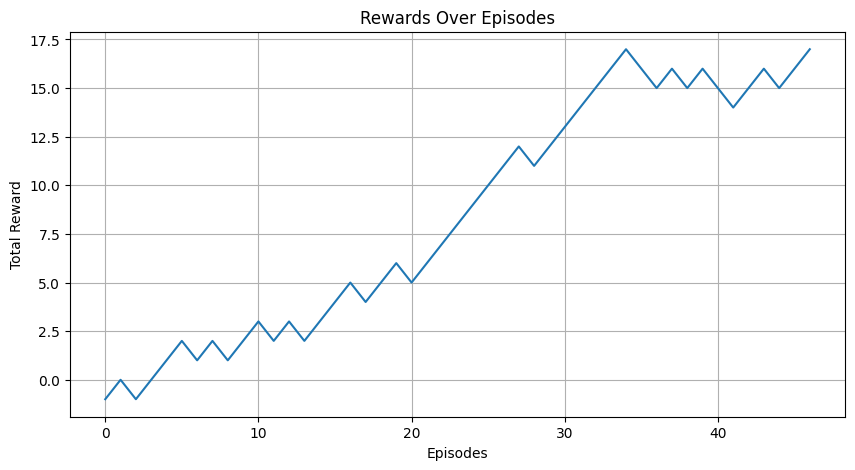

In [238]:
plt.figure(figsize=(10, 5))
plt.plot(rewards)
plt.title('Rewards Over Episodes')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

In [239]:
# play using trained polcicy

def trained_policy(agent, obs, columns):
    for j, _ in agent.policy.items():
        if j == tuple(obs.board):
            value = int(tuple(agent.policy.values()))
            return value
        else:
            return np.random.choice(columns)

In [240]:
env.run([trained_policy(agent4, obs, columns), df_negamax])
env.render(mode = 'ipython')

Invalid Action: Invalid column: 0


In [241]:
# Agent policy
for _ in range(len(agent4.policy)):
    print(agent4.policy.items())

Output hidden; open in https://colab.research.google.com to view.